In [6]:
!unzip /content/drive/MyDrive/DataSet_Misinfo_TRUE.zip



Archive:  /content/drive/MyDrive/DataSet_Misinfo_TRUE.zip
replace DataSet_Misinfo_TRUE.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [7]:
!unzip /content/drive/MyDrive/DataSet_Misinfo_FAKE.zip



Archive:  /content/drive/MyDrive/DataSet_Misinfo_FAKE.zip
replace DataSet_Misinfo_FAKE.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [8]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

import gensim

#IMPORTING

In [11]:
df_true=pd.read_csv('/content/DataSet_Misinfo_TRUE.csv')
df_fake=pd.read_csv('/content/DataSet_Misinfo_FAKE.csv')

# DATA CLEANING



In [12]:
df_true['label']=1
df_true=df_true.drop('Unnamed: 0',axis=1)
df_true.head()

,text,label
0,The head of a conservative Republican faction ...,1
1,Transgender people will be allowed for the fir...,1
2,The special counsel investigation of links bet...,1
3,Trump campaign adviser George Papadopoulos tol...,1
4,President Donald Trump called on the U.S. Post...,1


In [13]:
df_fake['label']=0
df_fake=df_fake.drop('Unnamed: 0',axis=1)
df_fake.head()

,text,label
0,Donald Trump just couldn t wish all Americans ...,0
1,House Intelligence Committee Chairman Devin Nu...,0
2,"On Friday, it was revealed that former Milwauk...",0
3,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis used his annual Christmas Day mes...,0


In [14]:
df=pd.concat([df_true,df_fake])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 78617 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78617 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [15]:
df=df.dropna(how="any")
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78588 entries, 0 to 43641
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    78588 non-null  object
 1   label   78588 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


#DATA PREPROCESSING


In [16]:
y = df["label"].values

X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

del df

#Why are word embeddings needed?

Let us consider the two sentences – “You can scale your business.” and “You can grow your business.”. These two sentences have the same meaning. If we consider a vocabulary considering these two sentences, it will constitute of these words: {You, can, scale, grow, your, business}.

A one-hot encoding of these words would create a vector of length 6. The encodings for each of the words would look like this:

You: [1,0,0,0,0,0], Can: [0,1,0,0,0,0], Scale: [0,0,1,0,0,0], Grow: [0,0,0,1,0,0],

Your: [0,0,0,0,1,0], Business: [0,0,0,0,0,1]

In a 6-dimensional space, each word would occupy one of the dimensions, meaning that none of these words has any similarity with each other – irrespective of their literal meanings.

#What is Word2Vec?

Word2Vec creates vectors of the words that are distributed numerical representations of word features – these word features could comprise of words that represent the context of the individual words present in our vocabulary. Word embeddings eventually help in establishing the association of a word with another similar meaning word through the created vectors.

As seen in the image below where word embeddings are plotted, similar meaning words are closer in space, indicating their semantic similarity.



In [17]:
EMBEDDING_DIM = 100

w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=EMBEDDING_DIM, window=5, min_count=1)

In [18]:
len(w2v_model.wv.index_to_key)

240843

In [19]:
w2v_model.wv["war"]

array([-0.8696255 , -1.007218  , -2.3845646 , -2.5802608 ,  1.5697916 ,
       -2.3348255 , -0.14437935, -3.3372436 ,  2.3297648 ,  1.5314226 ,
       -0.6404678 ,  1.9592721 , -4.4753175 , -2.7033248 ,  0.6859203 ,
       -1.061379  , -1.7723703 ,  0.70574975,  0.9981296 , -1.9895322 ,
       -0.356927  , -2.0753014 ,  1.7199347 ,  0.788194  , -3.9938068 ,
       -2.0725694 , -2.167575  ,  1.0915886 ,  1.9738199 ,  2.8600585 ,
        2.3709729 ,  1.8468255 ,  0.20181985, -0.25016695,  0.69883907,
       -1.7171342 , -0.533649  ,  0.27662358, -1.7239913 ,  1.9820917 ,
       -0.02204717, -1.7444003 , -0.9252877 , -1.0723207 ,  0.3264168 ,
       -6.1391315 ,  3.0278406 ,  3.5325804 ,  3.7410712 , -1.1257237 ,
        1.61084   , -0.9769289 , -0.37371364, -0.27008668,  0.36451054,
       -2.1189206 ,  2.0731454 , -1.2607696 ,  3.173937  ,  0.766681  ,
        1.0855292 ,  0.20203659,  3.1947205 , -3.2189376 ,  2.401022  ,
       -0.21362902,  1.6848559 ,  0.50405574, -0.42253625, -0.54

In [20]:
w2v_model.wv.most_similar("pandemic")

[('curable', 0.6911550760269165),
 ('influenza', 0.6897245645523071),
 ('outbreaks', 0.6873244047164917),
 ('virus', 0.6866676211357117),
 ('measles', 0.6814543604850769),
 ('infectious', 0.6761371493339539),
 ('epidemics', 0.674477219581604),
 ('opiate', 0.6736646890640259),
 ('viruses', 0.673224925994873),
 ('sars', 0.6687995195388794)]

In [21]:
w2v_model.wv.most_similar("innovation")

[('innovative', 0.7900538444519043),
 ('technological', 0.7684797048568726),
 ('sustainable', 0.7452629208564758),
 ('technology', 0.7315837740898132),
 ('ecosystem', 0.6876450777053833),
 ('competitiveness', 0.678678035736084),
 ('entrepreneurship', 0.6770355105400085),
 ('robotics', 0.6740713119506836),
 ('innovate', 0.6724787950515747),
 ('development', 0.6686419248580933)]

In [22]:
w2v_model.wv.most_similar(positive=["beatles","stones", "england"])

[('guitar', 0.7458440661430359),
 ('blues', 0.7241439819335938),
 ('menorah', 0.722564160823822),
 ('fountain', 0.7132142186164856),
 ('piano', 0.7104924917221069),
 ('clubhouse', 0.7057719230651855),
 ('glam', 0.704333484172821),
 ('bandleader', 0.7007930874824524),
 ('victorian', 0.7001422643661499),
 ('velvet', 0.6986154317855835)]

#Tokenization
Tokenization is a common task in Natural Language Processing (NLP). It’s a fundamental step in both traditional NLP methods like Count Vectorizer and Advanced Deep Learning-based architectures like Transformers.

Tokens are the building blocks of Natural Language.

Tokenization is a way of separating a piece of text into smaller units called tokens. Here, tokens can be either words, characters, or subwords. Hence, tokenization can be broadly classified into 3 types – word, character, and subword (n-gram characters) tokenization.

For example, consider the sentence: “Never give up”.

The most common way of forming tokens is based on space. Assuming space as a delimiter, the tokenization of the sentence results in 3 tokens – Never-give-up. As each token is a word, it becomes an example of Word tokenization.

Similarly, tokens can be either characters or subwords. For example, let us consider “smarter”:

Character tokens: s-m-a-r-t-e-r Subword tokens: smart-er

In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [24]:
X[0][:10]


[357, 305, 35, 6887, 135, 781, 200, 1008, 2696, 52]

In [25]:
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break

said -> 1
trump -> 2
would -> 3
people -> 4
president -> 5
one -> 6
mr -> 7
clinton -> 8
new -> 9
also -> 10


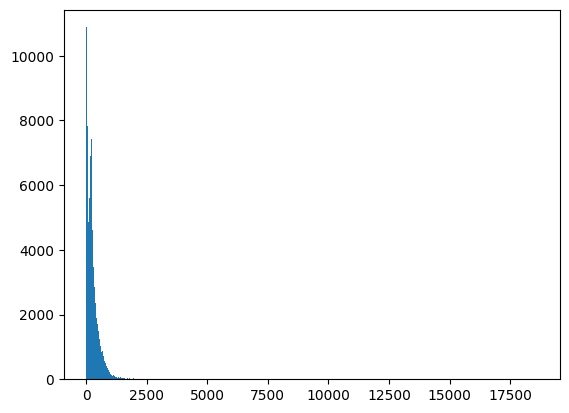

In [26]:
plt.hist([len(x) for x in X], bins=500)
plt.show()

In [27]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 1000])

76721

In [28]:
maxlen = 1000

X = pad_sequences(X, maxlen=maxlen)


In [29]:
len(X[0])

1000

In [30]:
vocab_size = len(tokenizer.word_index) + 1

In [31]:
def get_weight_matrix(model, vocab):
    vocab_size = len(vocab) + 1
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix

#Modeling
・Embedding vectors by word2vec for embbeding layer weight

In [32]:
embedding_vectors = get_weight_matrix(w2v_model.wv, word_index)

Neural Network with Non-trainable embeddidng layer and LSTM

In [33]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

del embedding_vectors

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 100)         24084400  
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 24201777 (92.32 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 24084400 (91.87 MB)
_________________________________________________________________


In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [36]:
model.fit(X_train, y_train, validation_split=0.3, epochs=2, batch_size=32)

Epoch 1/2
1290/1290 [==============================] - 56s 40ms/step - loss: 0.2491 - acc: 0.9008 - val_loss: 0.1746 - val_acc: 0.9341
Epoch 2/2
1290/1290 [==============================] - 54s 42ms/step - loss: 0.1491 - acc: 0.9427 - val_loss: 0.1252 - val_acc: 0.9519


In [37]:
y_pred = (model.predict(X_test) >= 0.5).astype("int")

614/614 [==============================] - 10s 15ms/step


In [38]:
accuracy_score(y_test, y_pred)

0.9541405812592253

In [39]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.96     10823
           1       0.95      0.94      0.95      8824

    accuracy                           0.95     19647
   macro avg       0.95      0.95      0.95     19647
weighted avg       0.95      0.95      0.95     19647

